In [1]:
from dask.distributed import Client
import multiprocessing
ncpu = multiprocessing.cpu_count()
threads = 6
nworker = ncpu//threads
print(f'Number of CPUs: {ncpu}, number of threads: {threads}, number of workers: {nworker}')

Number of CPUs: 48, number of threads: 6, number of workers: 8


In [2]:
client = Client(processes=True, threads_per_worker=threads, n_workers=nworker, memory_limit='256GB')
client

<Client: 'tcp://127.0.0.1:36700' processes=8 threads=48, memory=515.40 GB>

# Intake to load CMIP data

### Using intake-esm on mistral
- install intake-esm: https://intake-esm.readthedocs.io/en/latest/installation.html
- check the already built catalogs: `/home/mpim/m300524/intake-esm-datastore/catalogs` or `https://github.com/NCAR/intake-esm-datastore/` and skip long catalog building process of running `/home/mpim/m300524/intake-esm-datastore/builders/*.ipynb`

In [77]:
import intake
import xarray as xr
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import pprint
warnings.simplefilter("ignore")
%matplotlib inline
xr.set_options(keep_attrs=True)
import intake_esm
import pymistral
import cartopy.crs as ccrs
from climpred.stats import dpp, varweighted_mean_period
cmip6_post = '/work/mh0727/m300524/DCPP_post'

In [4]:
intake_esm.__version__

'2019.10.15.post33'

Credits to Julius Busecke for creating `cmip6_preprocessing`: https://github.com/jbusecke/cmip6_preprocessing

In [5]:
from cmip6_preprocessing.preprocessing import combined_preprocessing

In [6]:
combined_preprocessing??

Signature: combined_preprocessing(ds)
Docstring: <no docstring>
Source:   
def combined_preprocessing(ds):
    if 'AWI' not in ds.attrs['source_id']:
        ds = ds.copy()
        # fix naming
        ds = rename_cmip6(ds)
        # promote empty dims to actual coordinates
        ds = promote_empty_dims(ds)
        # broadcast lon/lat
        ds = broadcast_lonlat(ds)
        # replace x,y with nominal lon,lat
        ds = replace_x_y_nominal_lat_lon(ds)
        # shift all lons to consistent 0-360
        ds = correct_lon(ds)        
        # demote coordinates from data_variables (this is somehow reversed in intake)
        ds = correct_coordinates(ds)
        # fix the units
        ds = correct_units(ds)
    return ds
File:      /work/mh0727/m300524/miniconda3/envs/pymistral/lib/python3.7/site-packages/cmip6_preprocessing/preprocessing.py
Type:      function


# CMIP6

In [7]:
col_url = "/home/mpim/m300524/intake-esm-datastore/catalogs/mistral-cmip6.json"
col = intake.open_esm_datastore(col_url)

In [8]:
variable='tas'
table_id='Amon'
query = dict(experiment_id=['dcppA-hindcast'], table_id=table_id, 
             variable_id=variable, 
             #grid_label=['gn', 'gr']
            )
cat = col.search(**query)

print(cat.df['source_id'].unique())

['CESM1-1-CAM5-CMIP5' 'MPI-ESM1-2-HR' 'NorCPM1']


In [9]:
cat.df.head()

activity_id institution_id           source_id   experiment_id  \
1313968        DCPP           NCAR  CESM1-1-CAM5-CMIP5  dcppA-hindcast   
1313971        DCPP           NCAR  CESM1-1-CAM5-CMIP5  dcppA-hindcast   
1313982        DCPP           NCAR  CESM1-1-CAM5-CMIP5  dcppA-hindcast   
1313986        DCPP           NCAR  CESM1-1-CAM5-CMIP5  dcppA-hindcast   
1313992        DCPP           NCAR  CESM1-1-CAM5-CMIP5  dcppA-hindcast   

         member_id table_id variable_id grid_label  dcpp_init_year    version  \
1313968  r26i1p1f1     Amon         tas         gn          2006.0  v20191007   
1313971  r25i1p1f1     Amon         tas         gn          2008.0  v20191007   
1313982   r6i1p1f1     Amon         tas         gn          1985.0  v20191007   
1313986  r16i1p1f1     Amon         tas         gn          1967.0  v20191007   
1313992  r12i1p1f1     Amon         tas         gn          1961.0  v20191007   

            time_range                                               path  
1313968  200611-201612  /work/ik1017/CMIP6/data/CMIP6/DCPP/NCAR/CESM1-...  
1313971  200811-201812  /work/ik1017/CMIP6/data/CMIP6/DCPP/NCAR/CESM1-...  
1313982  198511-199512  /work/ik1017/CMIP6/data/CMIP6/DCPP/NCAR/CESM1-...  
1313986  196711-197712  /work/ik1017/CMIP6/data/CMIP6/DCPP/NCAR/CESM1-...  
1313992  196111-197112  /work/ik1017/CMIP6/data/CMIP6/DCPP/NCAR/CESM1-...

In [10]:
def climpred_pre(ds):
    """CMIP6 DCPP preprocessing."""
    # sometimes there is a small error in combined_preprocessing, therefore only try
    try:
        ds = combined_preprocessing(ds)
    except:
        print('preproc didnt work')
    ds['time'] = np.arange(1,1+ds.time.size)
    return ds

In [11]:
dset_dict = cat.to_dataset_dict(cdf_kwargs={
                                        'chunks': {'time': 120},
                                        'decode_times': False,
                                       },
                                    preprocess=climpred_pre
                                    )

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 3 group(s)


In [12]:
# available output
dset_dict.keys()

dict_keys(['DCPP.MPI-M.MPI-ESM1-2-HR.dcppA-hindcast.Amon.gn', 'DCPP.NCAR.CESM1-1-CAM5-CMIP5.dcppA-hindcast.Amon.gn', 'DCPP.NCC.NorCPM1.dcppA-hindcast.Amon.gn'])

In [13]:
# get first output
ds = dset_dict[list(dset_dict.keys())[2]].rename({
    'member_id':'member','dcpp_init_year':'init','time':'lead'})[variable].squeeze()

In [14]:
ds.nbytes/1e9,'GB'

(9.064434816, 'GB')

In [153]:
query = dict(experiment_id=['dcppA-assim'], table_id=table_id, 
             variable_id=variable, 
             #grid_label=['gn', 'gr']
            )
cat_assim = col.search(**query)

print(cat_assim.df['source_id'].unique())

['MIROC6']


In [150]:
dset_dict_assim = cat_assim.to_dataset_dict(cdf_kwargs={
                                        'chunks': {'time': 120},
                                        'decode_times': False,
                                       },
                                    preprocess=None
                                    )

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)


In [152]:
dset_dict_assim.keys()

dict_keys(['DCPP.MIROC.MIROC6.dcppA-assim.Amon.gn'])

# yearmean to prediction

In [118]:
def yearmean(ds, dim='time',initial_month='1'):
    was_int = False
    if isinstance(ds[dim].values[0], (np.int64, int)):
        print('set monthly time axis')
        was_int = True
        init_year = '0002' if initial_month is '1' else '0001'
        print(f'{init_year} {initial_month}')
        new_dim = xr.cftime_range(start=f'{init_year}-{str(initial_month).zfill(2)}',periods=ds[dim].size,freq='M')
        ds[dim] = new_dim
    #print(ds[dim])
    ds = ds.groupby(f'{dim}.year').mean(dim).rename({'year': dim})
    if not was_int:
        ds[dim] = xr.cftime_range(start=f'{init_year}-{str(initial_month).zfill(2)}',periods=ds[dim].size,freq='A')
    else:
        print('set one year back')
        ds[dim] = ds[dim] - 1
    return ds

In [136]:
model = 'MPI-ESM1-2-HR'
filename = f'{cmip6_post}/hind_{model}_{variable}.nc'
ds = xr.open_mfdataset(filename,chunks={'lead':12})[variable]

In [137]:
ds = yearmean(ds,dim='lead', initial_month=11).load()

set monthly time axis
0001 11


In [138]:
from climpred.prediction import compute_perfect_model
from climpred.stats import rm_trend

In [140]:
ds = rm_trend(ds.isel(lead=slice(1,None)),dim='lead')

In [142]:
s = compute_perfect_model(ds,ds,metric='pearson_r',comparison='m2e')

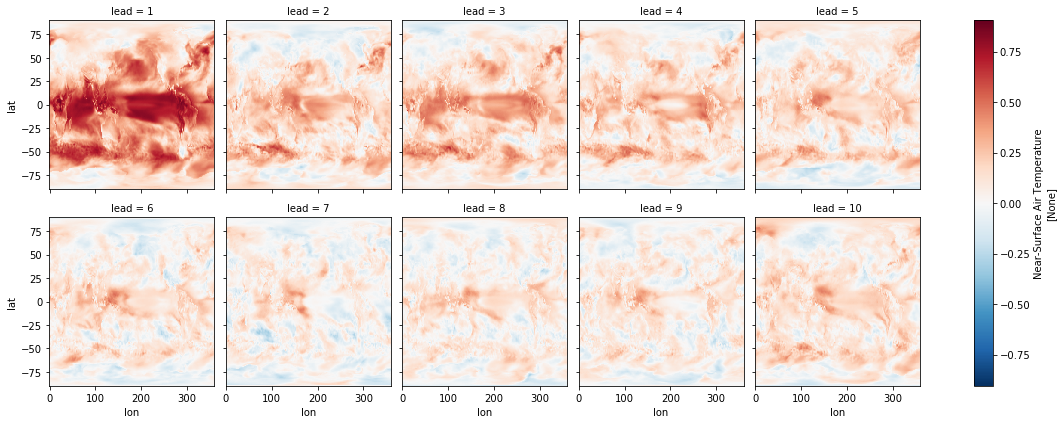

In [144]:
s.plot(col='lead',col_wrap=5)

In [ ]:
# save to file
for key,value in dset_dict.items():
    ds = dset_dict[key].rename({
    'member_id':'member','dcpp_init_year':'init','time':'lead'})[variable].squeeze()
    model = key.split('.')[2]
    filename = f'{cmip6_post}/hind_{model}_{variable}.nc'
    print(ds.nbytes/1e9,'GB',filename)
    try:
        if not os.path.exists(filename):
            ds.to_dataset(name=variable).to_netcdf(filename)
    except:
        print(f'{filename} error')